In [80]:
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

## This notebook has three parts:
- Generating data and visualization.
- Implementing FastICA
- Visualizing your prediction, which should be similar to S_noise

## 1. Generating data and visualization

In [81]:
n_samples = 2000
time = np.linspace(0, 8, n_samples)
s1 = np.sin(2 * time)  # sinusoidal
s2 = np.sign(np.sin(3 * time))  # square signal
s3 = signal.sawtooth(2 * np.pi * time)  # saw tooth signal

In [82]:
S_real = np.c_[s1, s2, s3]   # signal without noise

S_noise = np.c_[s1, s2, s3]  # signal with nosie
S_noise += 0.2 * np.random.normal(size=S_noise.shape)  # Add noise
S_noise /= S_noise.std(axis=0)  # Standardize data

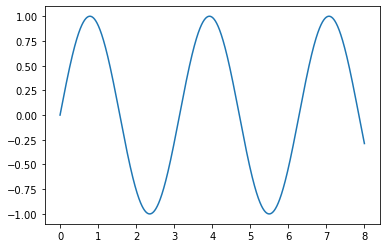

In [83]:
plt.plot(time,s1)
plt.show()

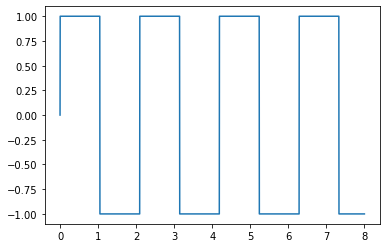

In [84]:
plt.plot(time,s2)
plt.show()

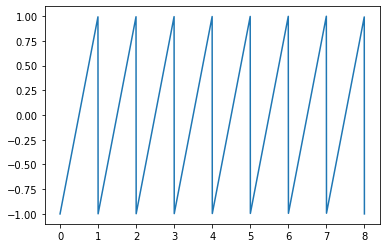

In [85]:
plt.plot(time,s3)
plt.show()

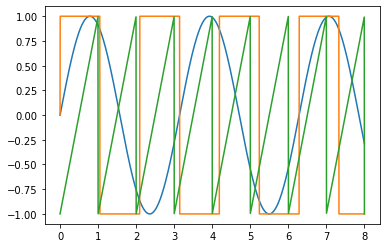

In [86]:
plt.plot(time,S_real)
plt.show()

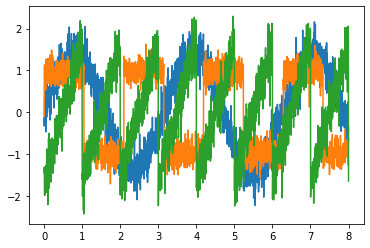

In [87]:
plt.plot(time,S_noise)
plt.show()

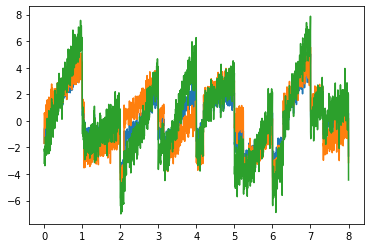

(3, 2000)


In [88]:
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S_noise, A.T)  # Generate noisy input x 
plt.plot(time,X)
plt.show()

X = X.T
print(X.shape)

## 2. FastICA
- Implement your FastICA algorithm here. 
- Feel free to define helper functions such as whiten(), g(), g_prime() et al.
- This is the **only part** that requires modification.

In [89]:
def g(x):
    return np.tanh(x)

def g1(x):
    return (1 - ((g(x))**2))

def whitening(X):
    X[0,:]=X[0,:]-np.mean(X[0,:])
    X[1,:]=X[1,:]-np.mean(X[1,:])
    X[2,:]=X[2,:]-np.mean(X[2,:])
    X_cov=np.cov(X)
    D,U=np.linalg.eig(X_cov)
    D=np.diag(D)
    X_bar=U@(np.sqrt(np.linalg.inv(D)))@(U.T)@X
    return X_bar

def w_update(W,X_bar):
    a,b=X_bar.shape
    w_new=np.zeros(a)
    for k in range(b):
        w_new+=((X_bar[:,k]*g((W.T)@(X_bar[:,k])))-(g1((W.T)@(X_bar[:,k]))*(W)))
    w_new=w_new/(b)
    return w_new

def w_normalize(w_new):
    w_norm =w_new/ np.sqrt((w_new ** 2).sum())
    return w_norm

def ICA(X, iterations=1000, tol=1e-5):
    X=whitening(X)
    a,b=X.shape
    W = np.random.rand(a,a)
    for i in range(a):
        w=W[:,i]
        for j in range(iterations):
            w_new = w_update(w, X)
            if i >= 1:
                sum1=0
                for j in range(i):
                    sum1+=((w_new.T@W[:,j])*(W[:,j]))
                w_new=w_new-sum1
            w_new=w_normalize(w_new)
            error = np.abs(np.abs((w * w_new).sum()) - 1)
            w = w_new
            if error < tol:
                break
            else:
                w=w_new
        W[ :,i] = w
    S = (W.T)@X
    return S,W

## 3. Prediction visualization
- Run your FastICA algorithm and visualize S, which should look like S_noise

In [90]:
S,W = ICA(X)

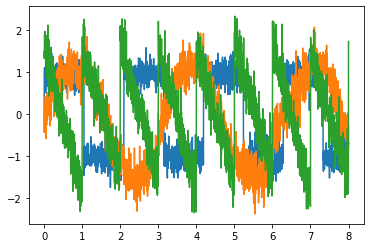

In [91]:
for i in range(S.shape[0]):
    plt.plot(time, S[i])